In [1]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


fatal: destination path 'ELENA' already exists and is not an empty directory.
/content/ELENA


In [2]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [3]:
%%writefile /content/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

# Entropy density of the SM plasma (approximate, constant g_star)
g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Overwriting /content/utils.py


In [4]:
%%writefile /content/ELENA/src/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Overwriting /content/ELENA/src/utils.py


In [5]:
from google.colab import files
uploaded = files.upload()



Saving ah_pot.m to ah_pot (1).m


In [6]:
#!/usr/bin/env python3
"""
Generic converter from a Mathematica DRalgo-style potential

    V[field_, T_] := expr

to a Python module potential_3d.py with

    def V(phi, T)
    def dV(phi, T)

that is numerically stable and ELENA-compatible.

- Works for ANY thermal potential with one scalar field and temperature T.
- Automatically detects all other symbols as parameters that must be provided
  by get_params(T).

Usage:
  1. Put your Mathematica definition (one line) into INPUT_FILE
     e.g.:
       V[phi_, T_] := (msq*ϕ^2)/2 + (λ*ϕ^4)/4 - ...

  2. Run:
       python generate_potential_generic.py

  3. You get `potential_3d.py`. Open it and implement get_params(T).
"""

import sympy as sp
from pathlib import Path
import re

# You already set this:
INPUT_FILE  = "ah_pot.m"
OUTPUT_FILE = "potential_3d.py"


# ------------------------------------------------------------------
# Helpers: Mathematica → SymPy-friendly string
# ------------------------------------------------------------------

# Common symbol name mappings used by DRalgo / SM / BSM models
MMA_SYMBOL_MAP = {
    # Field aliases (Unicode & escaped forms)
    "ϕ": "phi",
    "φ": "phi",
    "\\[CurlyPhi]": "phi",
    "\\[Phi]": "phi",

    # Lambdas
    "λ": "lam",
    "\\[Lambda]": "lam",
    "\\[Lambda]1H": "lam1H",

    # Mus / renormalisation scales
    "μ3US": "mu3US",
    "\\[Mu]3US": "mu3US",
    "\\[Mu]": "mu",

    # Hypercharges / generic charges / angles
    "Yϕ": "Yphi",
    "\\[Alpha]": "alpha",
    "\\[Beta]": "beta",

    # Standard Mathematica builtins
    "Pi": "pi",
    "Sqrt": "sqrt",
    "Log": "log",
}


def extract_def_line(mathematica_str: str):
    """
    Find the last definition line of the form

        V[field_, T_] := expr

    and return:

        field_name, T_name, rhs_string

    with field_name / T_name stripped of underscores.
    """
    lines_with_def = [ln for ln in mathematica_str.splitlines() if ":=" in ln]
    if not lines_with_def:
        raise ValueError("Could not find ':=' in input file.")

    last = lines_with_def[-1]

    # Extract the part between 'V[' and ']:='
    try:
        inside = last.split("V[", 1)[1].split("]:=", 1)[0]
    except IndexError as e:
        raise ValueError(
            "Could not parse the V[field_, T_] definition line. "
            "Make sure it has the form 'V[phi_, T_] := ...'."
        ) from e

    # Split arguments: e.g. "phi_, T_" -> "phi_", "T_"
    parts = [p.strip() for p in inside.split(",")]
    if len(parts) != 2:
        raise ValueError(
            f"Expected two arguments in V[...], found: {inside!r}"
        )

    field_part, T_part = parts
    field_name = field_part.replace("_", "").strip()
    T_name     = T_part.replace("_", "").strip()

    rhs = last.split(":=", 1)[1].strip()
    return field_name, T_name, rhs


def mathematica_to_sympy(expr: str) -> str:
    """
    Generic textual conversion from Mathematica syntax to something SymPy can parse.
    Handles:
      - greek / escaped letters like ϕ, \\[CurlyPhi], λ, \\[Lambda]1H, μ3US, \\[Mu]3US
      - Pi, Sqrt, Log
      - power ^ to **
      - [ ] to ( )
    Everything else is left untouched so it's model-agnostic.
    """
    # Symbol-level replacements
    for old, new in MMA_SYMBOL_MAP.items():
        expr = expr.replace(old, new)

    # Structural replacements
    expr = expr.replace("^", "**")
    expr = expr.replace("[", "(")
    expr = expr.replace("]", ")")
    return expr


def make_half_powers_safe(expr: sp.Expr) -> sp.Expr:
    """
    Replace half-integer powers x^(n/2) with Abs(x)^(n/2) to avoid complex/NaN
    when x is slightly negative due to numerics.

    This catches things like (msq + lam*phi**2)**(3/2), ( ... )**(1/2), etc.
    """

    def repl_pow(e):
        if isinstance(e, sp.Pow) and isinstance(e.exp, sp.Rational) and e.exp.q == 2:
            # e.base**(m/2)  ->  Abs(e.base)**(m/2)
            return sp.Pow(sp.Abs(e.base), e.exp)
        return e

    return expr.replace(
        lambda e: isinstance(e, sp.Pow)
        and isinstance(e.exp, sp.Rational)
        and e.exp.q == 2,
        repl_pow,
    )


def sympy_to_numpy_code(expr: sp.Expr) -> str:
    """
    Convert SymPy expression to a Python/NumPy-friendly code string.
    - uses sympy.pycode
    - then replaces sqrt/log/pi/Abs with safe NumPy wrappers
    """
    code = sp.pycode(expr)  # e.g. sqrt(...), log(...), pi, Abs(...)

    # sqrt -> _rtabs (numerically safe absolute sqrt)
    code = re.sub(r"\bsqrt\(", "_rtabs(", code)

    # log -> _logsafe (numerically safe log)
    code = re.sub(r"\blog\(", "_logsafe(", code)

    # pi -> np.pi
    code = re.sub(r"\bpi\b", "np.pi", code)

    # Abs -> np.abs
    code = re.sub(r"\bAbs\(", "np.abs(", code)

    return code


# ------------------------------------------------------------------
# Main generator
# ------------------------------------------------------------------

def main():
    # 1. Read Mathematica potential
    src = Path(INPUT_FILE).read_text(encoding="utf-8")

    # Extract field / T names and RHS of the potential
    field_name_raw, T_name_raw, rhs_raw = extract_def_line(src)
    rhs_sympy_like = mathematica_to_sympy(rhs_raw)

    # 2. Build SymPy expression
    # We *canonicalise* the Python interface to use 'phi' and 'T'
    phi, T = sp.symbols("phi T", real=True)

    # Let SymPy create symbols for anything else automatically.
    # Map both the original Mathematica argument names and the
    # canonical names so it works whether rhs uses 'phi' or '\\[CurlyPhi]'.
    local_map = {
        field_name_raw: phi,
        T_name_raw: T,
        "phi": phi,
        "T": T,
        "sqrt": sp.sqrt,
        "log": sp.log,
        "pi": sp.pi,
    }

    V_expr = sp.sympify(rhs_sympy_like, locals=local_map)

    # 2b. Make all half-integer powers sqrt-safe
    V_expr = make_half_powers_safe(V_expr)

    # 3. Find all free parameters (symbols) except phi and T
    free_syms = V_expr.free_symbols
    free_syms = sorted(free_syms, key=lambda s: s.name)
    param_syms = [s for s in free_syms if s not in (phi, T)]

    param_names = [s.name for s in param_syms]
    param_names_str = ", ".join(param_names) if param_names else "(none)"

    # Some light classification (just for the header)
    gauge_like   = [n for n in param_names if n.startswith("g")]
    quartic_like = [n for n in param_names if n.startswith("lam")]
    mass_like    = [n for n in param_names if n.startswith("m") or n.endswith("2")]

    # 4. Convert expression to NumPy-friendly string
    V_numpy = sympy_to_numpy_code(V_expr)

    # 5. Build the potential_3d.py text
    header = f'''"""
Auto-generated potential_3d.py from Mathematica DRalgo output.

Original definition:
    V[{field_name_raw}_, {T_name_raw}_] := ...

Python interface:
    V(phi, T)  — one-field 3D effective potential (thermal or not)
    dV(phi, T) — finite-difference derivative wrt phi

Detected free parameters (besides phi, T):
    {param_names_str}

Rough classification:
    - gauge-like:   {", ".join(gauge_like)   or "none detected"}
    - quartic-like: {", ".join(quartic_like) or "none detected"}
    - mass-like:    {", ".join(mass_like)    or "none detected"}

You MUST implement get_params(T) below to provide numerical values
for these parameters at any given temperature T.

Typical usage in ELENA:
    from potential_3d import V, dV
"""

import numpy as np

# ---------- numerically safe helpers ----------

def _rtabs(x, floor=1e-30):
    \"\"\"sqrt(|x|) with a floor to avoid NaNs from tiny negatives.\"\"\"
    x = np.asarray(x, dtype=float)
    return np.sqrt(np.maximum(np.abs(x), floor))

def _logsafe(x, floor=1e-30):
    \"\"\"log(|x|) with a floor to avoid log(0) / log(negative) issues.\"\"\"
    x = np.asarray(x, dtype=float)
    return np.log(np.maximum(np.abs(x), floor))


def get_params(T):
    \"\"\"
    USER MUST IMPLEMENT.

    Given a temperature T (float), return a dict mapping parameter names to values.
    Required keys:
        {param_names_str}

    Example:
        return dict(msq=..., lam=..., gw=..., gY=..., mu3US=...)
    \"\"\"
    raise NotImplementedError(
        "Implement get_params(T) so that it returns a dict with keys: {param_names_str}"
    )

'''

    # parameter extraction inside V
    if param_names:
        param_extract_lines = [
            f"    {name} = params['{name}']"
            for name in param_names
        ]
    else:
        param_extract_lines = ["    # no extra parameters"]
    param_extract_code = "\n".join(param_extract_lines)

    V_def = f'''
def V(phi, T):
    \"\"\"3D effective potential V(phi, T) translated from Mathematica.\"\"\"
    phi = np.asarray(phi, dtype=float)
    T = float(T)

    params = get_params(T)
{param_extract_code}

    return {V_numpy}
'''

    dV_def = r'''
def dV(phi, T, h_rel=1e-3, h_abs=1e-5):
    """
    Numerical derivative dV/dphi via symmetric finite differences.
    Works for scalar phi or NumPy arrays of phi.
    """
    phi = np.asarray(phi, dtype=float)
    T = float(T)

    h = h_rel * np.maximum(np.abs(phi), 1.0) + h_abs
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)
'''

    out_text = header + V_def + dV_def
    Path(OUTPUT_FILE).write_text(out_text, encoding="utf-8")
    print(f"Wrote {OUTPUT_FILE} with generic V(phi,T) and dV(phi,T).")
    print("Free parameters:", param_names_str)


if __name__ == "__main__":
    main()


Wrote potential_3d.py with generic V(phi,T) and dV(phi,T).
Free parameters: Yphi, g1, lam, msq, mu3US


In [7]:
from pathlib import Path

# 1. Load the current potential_3d.py
path = Path("potential_3d.py")
text = path.read_text()

# 2. New full definition of get_params(T)
new_get_params = """
def get_params(T):
    \"""
    4D → 3D matching for Abelian Higgs model (example / placeholder).

    Returns a dict with keys:
        Yphi, g1, lam, msq, mu3US
    \"""
    T = float(T)

    # ---- 4D input couplings (set these to your DRalgo values) ----
    g1_4   = 0.54
    lam_4  = 1.65e-3
    m0sq_4 = -(130.0**2)
    Yphi_4 = 1.0

    # ---- Simple DR-like matching (you can refine later) ----
    g1sq_3 = (g1_4**2) * T                  # 3D gauge coupling squared
    lam_3  = lam_4 * T                      # 3D quartic
    msq_3  = m0sq_4 + (0.30*(g1_4**2) + 0.10*lam_4) * T*T
    mu3US  = max(g1_4 * T, 1.0)             # 3D renormalisation scale

    # Convert g1^2 → g1 for the potential
    g1_3 = np.sqrt(g1sq_3)
    Yphi = Yphi_4

    return dict(
        Yphi=Yphi,
        g1=g1_3,
        lam=lam_3,
        msq=msq_3,
        mu3US=mu3US,
    )
"""

# 3. Replace everything from 'def get_params(T):' up to the next 'def V('
start = text.index("def get_params(T):")
end   = text.index("def V(", start)   # assume V is the next function after get_params

new_text = text[:start] + new_get_params + "\n\n" + text[end:]

# 4. Write patched file
path.write_text(new_text)



7745

In [8]:

import re
from pathlib import Path

path = Path("potential_3d.py")
text = path.read_text()

# Remove all math. prefixes
text = text.replace("math._rtabs", "_rtabs")
text = text.replace("math._logsafe", "_logsafe")
text = text.replace("math.np.pi", "np.pi")
text = text.replace("math.", "")   # remove any leftover math.

# Clean accidental double prefixes
text = text.replace("np.np", "np")

# Write cleaned file
path.write_text(text)



7380

In [9]:
%%writefile custom_model.py
from potential_3d import V as V_raw, dV as dV_raw

class CustomModel:
    """
    Minimal drop-in replacement for `model`:
    exposes DVtot and gradV, wrapping your custom V and dV.
    """
    def __init__(self, vev, lambda_, g, xstep, Tstep, units="MeV"):
        self.vev     = vev
        self.lambda_ = lambda_
        self.g       = g
        self.xstep   = xstep
        self.Tstep   = Tstep
        self.units   = units

        # If you want rescaling by units, do it here.
        # For now: just pass through to your potential.
        self.DVtot = lambda phi, T: V_raw(phi, T)
        self.gradV = lambda phi, T: dV_raw(phi, T)


Overwriting custom_model.py


In [10]:
import numpy as np
from utils import convert_units
from custom_model import CustomModel  # instead of `from model import model`

# You can still choose units randomly if you like
units = np.random.choice(list(convert_units.keys()))

# Parameters
lambda_ = 1.65e-3
g       = 0.54
vev, units = 500, "MeV"
description = "Fast"

# Construct "model" using your custom potential
dp = CustomModel(vev, lambda_, g,
                 xstep = vev * 1e-3,
                 Tstep = vev * 1e-3,
                 units = units)

V  = dp.DVtot   # this now points to your big V(phi,T)
dV = dp.gradV   # this now points to your big dV(phi,T)

print(f"lambda = {lambda_}")
print(f"g      = {g}")
print(f"vev    = {vev} {units}")


phi_test = 10.0
T_test   = 150.0
print("V(10, 150) =", V(phi_test, T_test))
print("dV(10, 150) =", dV(phi_test, T_test))


lambda = 0.00165
g      = 0.54
vev    = 500 MeV
V(10, 150) = -843463.6121643414
dV(10, 150) = -152450.76936889338


/content/ELENA/potential_3d.py:88: RuntimeWarning: invalid value encountered in divide
  return (1/16)*Yphi**2*g1**2*abs(phi)*_rtabs(abs(Yphi**2*g1**2))*_rtabs(abs(lam*phi**2 + msq))/np.pi**2 + (1/16)*Yphi**2*g1**2*abs(phi)*_rtabs(abs(Yphi**2*g1**2))*_rtabs(abs(3*lam*phi**2 + msq))/np.pi**2 - 1/16*lam**2*phi**2*(_logsafe(mu3US/(2*_rtabs(abs(lam*phi**2 + msq)) + _rtabs(abs(3*lam*phi**2 + msq)))) + 1/2)/np.pi**2 - 3/16*lam**2*phi**2*(_logsafe((1/3)*mu3US/_rtabs(abs(3*lam*phi**2 + msq))) + 1/2)/np.pi**2 + (1/4)*lam*phi**4 + (3/64)*lam*(lam*phi**2 + msq)/np.pi**2 + (3/64)*lam*(3*lam*phi**2 + msq)/np.pi**2 + (1/32)*lam*_rtabs(abs(lam*phi**2 + msq))*_rtabs(abs(3*lam*phi**2 + msq))/np.pi**2 + (1/2)*msq*phi**2 - 1/6*phi**2*abs(phi)*abs(Yphi**2*g1**2)**(3/2)/np.pi - 1/12*abs(lam*phi**2 + msq)**(3/2)/np.pi - 1/12*abs(3*lam*phi**2 + msq)**(3/2)/np.pi + (1/4)*((1/4)*lam**2*phi**4*(_logsafe(mu3US/(_rtabs(abs(lam*phi**2 + msq)) + _rtabs(abs(3*lam*phi**2 + msq)))) + 1/2)/np.pi**2 - 1/16*(Yphi**2*g1**

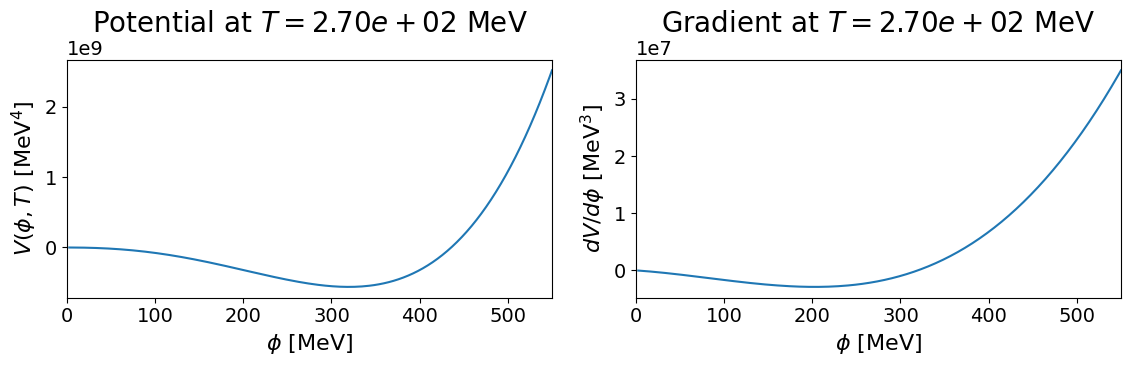

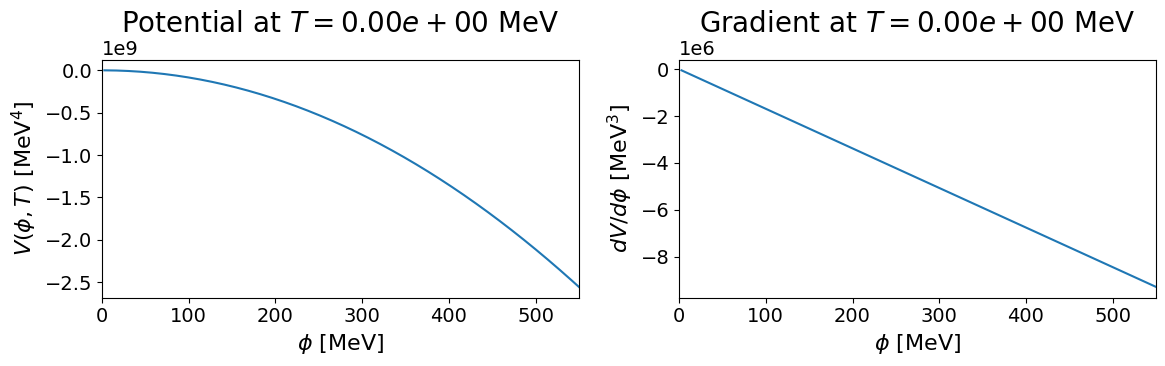

In [11]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=SyntaxWarning)

# Set global font size parameters
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20,
    'text.usetex': False    # <<< IMPORTANT for Colab
})

T = np.random.uniform(0, vev)

phi = np.linspace(0, 1.1 * vev, 200)
phi = phi.reshape(-1,1)

for t in [T, 0]:
    v = V(phi, t)
    dv = dV(phi, t)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(phi, v)
    axes[0].set_title(f"Potential at $T = {t:.2e}$ {units}")
    axes[0].set_xlabel(f"$\\phi$ [{units}]")
    axes[0].set_ylabel(f"$V(\\phi, T)$ [{units}$^4$]")

    axes[1].plot(phi[1:], dv[1:])
    axes[1].set_title(f"Gradient at $T = {t:.2e}$ {units}")
    axes[1].set_xlabel(f"$\\phi$ [{units}]")
    axes[1].set_ylabel(f"$dV/d\\phi$ [{units}$^3$]")

    for ax in axes:
        ax.set_xlim(phi[0], phi[-1])

    plt.tight_layout()
    plt.show()



In [12]:
%%writefile veff_4d.py
"""
veff_4d.py – 4D one-loop + high-T thermal potential for the Abelian–Higgs model.

It shares the SAME 4D parameters (g, lambda, m0^2)
"""

import numpy as np

# ---------- 4D input couplings (same as in veff_elena / potential_3d) ----------
g4    = 0.54         # gauge coupling
lam4  = 1.65e-3      # quartic
m0sq4 = -(130.0**2)  # bare mass^2
Yphi  = 1.0          # U(1) charge of scalar

# ---------- mass spectra (Landau gauge, tree level) ----------

def m_h2(phi):
    """Higgs mass^2: m^2 + 3 λ φ^2."""
    return m0sq4 + 3.0*lam4*phi*phi

def m_G2(phi):
    """Goldstone mass^2: m^2 + λ φ^2 (Landau gauge)."""
    return m0sq4 + lam4*phi*phi

def m_A2(phi):
    """Gauge boson mass^2: g^2 Y^2 φ^2."""
    return (g4*Yphi)**2 * phi*phi

# Degeneracy factors (d.o.f.) – you can tweak if you want
n_h = 1.0   # one real Higgs
n_G = 1.0   # one real Goldstone
n_A = 3.0   # 3 polarisations of massive vector (roughly)

# ---------- tree-level potential ----------

def V_tree(phi):
    """Tree-level scalar potential in 4D."""
    return 0.5*m0sq4*phi*phi + 0.25*lam4*(phi**4)


# ---------- high-T bosonic thermal piece ----------

def V_T_boson(m2, n, T):
    """
    High-T expansion of bosonic thermal potential (keeping T^2 and cubic term):

    ΔV_T ≈ n * [ (m^2 T^2)/24  -  (m^3 T)/(12π) ]

    Constant -π^2 T^4/90 and logarithmic m^4 ln(m^2/T^2) terms are dropped
    because they are φ-independent or subleading for our comparison goal.
    """
    T = float(T)
    m2 = np.asarray(m2, dtype=float)
    m2_clip = np.maximum(m2, 0.0)   # avoid sqrt of negative
    m  = np.sqrt(m2_clip)

    term_T2 = (m2 * (T**2)) / 24.0
    term_T3 = - (m**3 * T) / (12.0 * np.pi)

    return n * (term_T2 + term_T3)


# ---------- full 4D one-loop + thermal effective potential ----------

def V(phi, T):
    """
    4D one-loop + thermal potential V_4D(φ,T) in high-T approximation.

    This is METHOD 2 (4D) to compare with your 3D DR potential.
    """
    phi = np.asarray(phi, dtype=float)
    T   = float(T)

    # tree level
    V0 = V_tree(phi)

    # masses
    mh2 = m_h2(phi)
    mG2 = m_G2(phi)
    mA2 = m_A2(phi)

    # thermal pieces (bosons only)
    VTh = V_T_boson(mh2, n_h, T)
    VTG = V_T_boson(mG2, n_G, T)
    VTA = V_T_boson(mA2, n_A, T)

    return V0 + VTh + VTG + VTA



# ---------- numerical derivative dV/dφ ----------

def dV(phi, T):
    """
    Numerical derivative dV/dφ using a symmetric finite difference.

    Step size is independent of φ near zero to stay stable with |φ| cusps.
    """
    phi = np.asarray(phi, dtype=float)
    T   = float(T)
    h = 1e-3 * np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)


if __name__ == "__main__":
    # quick sanity print
    Ts = [0.0, 50.0, 100.0, 150.0, 200.0]
    for T in Ts:
        for ph in [0.0, 10.0, 50.0, 200.0]:
            print(f"T={T:6.1f}, phi={ph:7.2f}, V4D={V(ph,T): .4e}, dV4D={dV(ph,T): .4e}")
        print("-"*50)


Writing veff_4d.py


In [13]:
import numpy as np
import matplotlib.pyplot as plt

from potential_3d import V as V_DR, dV as dV_DR    # your 3D DR potential
from veff_4d   import V as V_4D, dV as dV_4D    # new 4D potential


In [14]:
def compare_DR_vs_4D_multi(phi, Ts, units=r"\mathrm{MeV}"):


    import numpy as np
    import matplotlib.pyplot as plt

    plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,  # True if you have LaTeX in your environment
})


    # Ensure phi is 1D for plotting
    phi = np.asarray(phi).reshape(-1)

    # Round temperatures for nice labels
    Ts = np.asarray(Ts, dtype=float)
    Ts_round = Ts.astype(int)

    # Figure & axes
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Nice global style tweaks
    for ax in axes.flat:
        ax.tick_params(direction="in", top=True, right=True)
        ax.grid(alpha=0.25)

    # Colour map: same colour for a given T (solid=DR, dashed=4D)
    colors = plt.cm.viridis(np.linspace(0, 1, len(Ts_round)))

    for T, Tlab, color in zip(Ts, Ts_round, colors):
        V1  = V_DR(phi, T)
        V2  = V_4D(phi, T)-V_4D(0.0, T)
        dV1 = dV_DR(phi, T)
        dV2 = dV_4D(phi, T)

        dVpot = V1 - V2
        dGrad = dV1 - dV2

        # --- Potentials ---
        axes[0, 0].plot(phi, V1,  color=color, ls="-",
                        label=rf"DR, $T={Tlab}$")
        axes[0, 0].plot(phi, V2,  color=color, ls="--",
                        label=rf"4D, $T={Tlab}$")

        # --- ΔV ---
        axes[0, 1].plot(phi, dVpot, color=color,
                        label=rf"$T={Tlab}$")

        # --- Gradients ---
        axes[1, 0].plot(phi, dV1, color=color, ls="-",
                        label=rf"DR, $T={Tlab}$")
        axes[1, 0].plot(phi, dV2, color=color, ls="--",
                        label=rf"4D, $T={Tlab}$")

        # --- Δ(dV) ---
        axes[1, 1].plot(phi, dGrad, color=color,
                        label=rf"$T={Tlab}$")

    # Horizontal zero lines for the difference plots
    axes[0, 1].axhline(0.0, ls="--", color="grey", lw=1)
    axes[1, 1].axhline(0.0, ls="--", color="grey", lw=1)

    # Titles and axis labels
    axes[0, 0].set_title(r"$V_{\mathrm{eff}}(\phi, T)$")
    axes[0, 1].set_title(r"$\Delta V(\phi, T) = V_{\rm DR} - V_{\rm 4D}$")
    axes[1, 0].set_title(r"$\partial_\phi V_{\mathrm{eff}}(\phi, T)$")
    axes[1, 1].set_title(r"$\Delta(\partial_\phi V) = \partial_\phi V_{\rm DR} - \partial_\phi V_{\rm 4D}$")

    axes[1, 0].set_xlabel(r"$\phi\ [{"+units+"}]$")
    axes[1, 1].set_xlabel(r"$\phi\ [{"+units+"}]$")

    axes[0, 0].set_ylabel(r"$V_{\mathrm{eff}}\ [{"+units+r"}^4]$")
    axes[0, 1].set_ylabel(r"$\Delta V\ [{"+units+r"}^4]$")
    axes[1, 0].set_ylabel(r"$\partial_\phi V\ [{"+units+r"}^3]$")
    axes[1, 1].set_ylabel(r"$\Delta(\partial_\phi V)\ [{"+units+r"}^3]$")

    # Legends (smaller, non-overlapping)
    axes[0, 0].legend(frameon=False, fontsize=11, ncol=2)
    axes[0, 1].legend(frameon=False, fontsize=11)
    axes[1, 0].legend(frameon=False, fontsize=11, ncol=2)
    axes[1, 1].legend(frameon=False, fontsize=11)

    plt.tight_layout()
    plt.show()


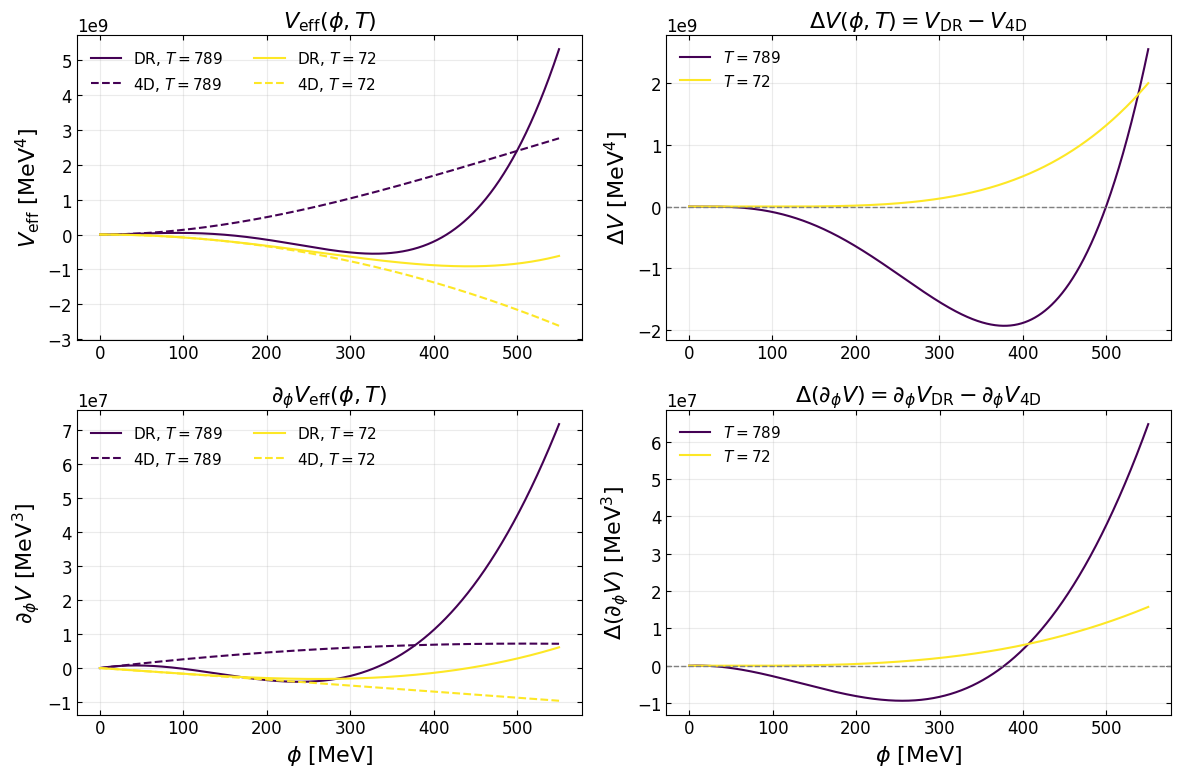

In [15]:
phi = np.linspace(0, 1.1*vev, 2601)
phi = phi.reshape(-1,1)
Ts  = np.random.uniform(0, 2.5*vev, size=2)
Ts = np.round(Ts).astype(int)
compare_DR_vs_4D_multi(phi, Ts)
